In [1]:
import torch
import numpy as np
from torch import nn
import torch.nn.functional as F
from dynamics_env.dynamics_ma import Dynamics
from tqdm import tqdm
import matplotlib.pyplot as plt
plt.rcParams['font.size'] = 15
import pandas as pd

In [2]:
file_name = 'sanity_two_body_bar_1kpc'
seed = 0

In [3]:
results_file = f'runs/Dynamics-v0__{file_name}_best_performers.csv'

In [4]:
def make_env(seed):
        def thunk():
            env = Dynamics(hyperparameters={
                'stationary_potential_list':['bar'],
                'stationary_potential_kwargs_list':[{'M':1e10, 'a':5000, 'b':1500, 'c':1000, 'omega_p':0.0}],
                # 'stationary_potential_list':['point_source'],
                # 'stationary_potential_kwargs_list':[{'M':1e10}],
                'stationary_potential_list':[],
                'stationary_potential_kwargs_list':[{}],
                'dynamic_potential_list':['point_source','point_source'],
                # 'dynamic_potential_list':['tracer','tracer'],
                'dynamic_potential_kwargs_list':[{'M':1e10}, {'M':1e10}],
                'seed':seed,
                'box_scaling':1000,
                'orbit_duration':100,
                'orbit_timesteps':100,
            })
            env.action_space.seed(seed)
            env.observation_space.seed(seed)
            return env
        return thunk
env = make_env(seed=seed)()

def plot_from_init(init_params):
    env.reset()
    print(init_params)
    init_params = {key:value/env.high for key,value in init_params.items()}
    _, reward, _, _, info = env.step(init_params)
    orbit = info['orbit']
    orbit_delta = info['orbit_delta']
    reverse_orbit_init_params = orbit.y[:,-1]
    reverse_orbit_delta_init_params = orbit_delta.y[:,-1]
    reverse_orbit = env.reverse_leapfrog_verlet(env.get_acceleration, t_span=(0, env.orbit_duration), y0=reverse_orbit_init_params, delta_t=env.orbit_duration / env.orbit_timesteps)
    reverse_orbit_delta = env.reverse_leapfrog_verlet(env.get_acceleration, t_span=(0, env.orbit_duration), y0=reverse_orbit_delta_init_params, delta_t=env.orbit_duration / env.orbit_timesteps)
    fig = plt.figure(figsize=(30, 10))
    ax1 = fig.add_subplot(131, projection='3d')
    ax1.set_xlabel('X')
    ax1.set_ylabel('Y')
    ax1.set_zlabel('Z')

    for agent in range(env.num_agents):
        ax1.plot(orbit.y[agent*6], orbit.y[agent*6+1], orbit.y[agent*6+2], lw=0.5, label=r'$O_%d$'%agent)
        ax1.plot(orbit_delta.y[agent*6], orbit_delta.y[agent*6+1], orbit_delta.y[agent*6+2], lw=0.5, label=r'$O_{\delta%d}$'%agent)
        ax1.scatter(orbit.y[agent*6+0][0], orbit.y[agent*6+1][0], orbit.y[agent*6+2][0], label='Trajectory %d start'%agent)
    ax2 = fig.add_subplot(132)
    
    # ax2.scatter(0, 0, label='Source')
    ax2.set_xlabel('X')
    ax2.set_ylabel('Y')
    ax2.set_title('Projected Orbit')
    for agent in range(env.num_agents):
        ax2.plot(orbit.y[agent*6+0], orbit.y[agent*6+1], lw=2, label=r'$O_%d$'%agent)
        ax2.plot(orbit_delta.y[agent*6+0], orbit_delta.y[agent*6+1], lw=2, label=r'$O_{\delta%d}$'%agent)
        ax2.scatter(orbit.y[agent*6+0][0], orbit.y[agent*6+1][0], label='Trajectory %d start'%agent)
    ax1.set_title(f'3D Orbit')

    ax3 = fig.add_subplot(133)
    ax3.plot((orbit.y-reverse_orbit.y).sum(axis=0))
    ax3.set_title(f'Orbit-reverse-orbit distances: {(orbit.y - reverse_orbit.y).sum()}')
        
    print(reward)
    ax1.legend()
    ax2.legend()
    # ax3.legend()

[ENV] Using cpu
[ENV] Seed set to 0


Text(0.5, 1.0, 'Initial positions studied, projected on the XY plane')

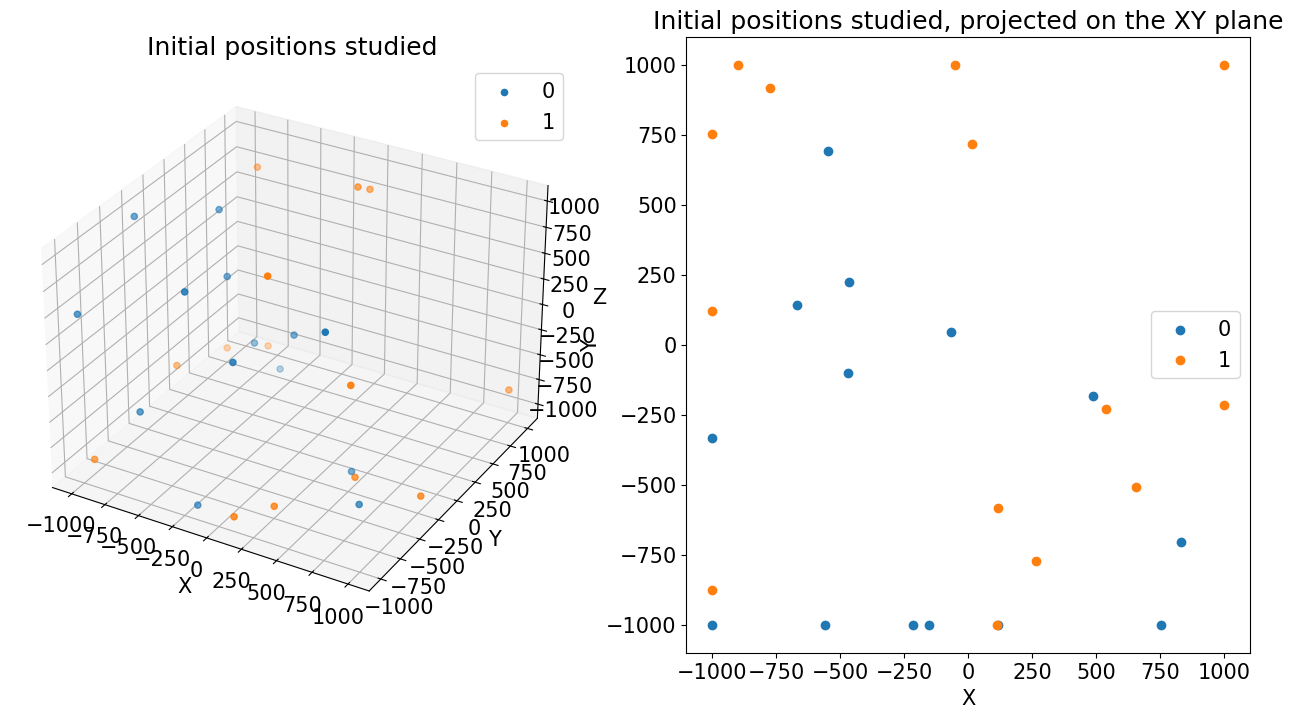

In [5]:
results = pd.read_csv(results_file).sort_values(by=['reward'], ascending=False)
result_init_params = {i:results.iloc[:, [j for j in range(i * 6+1, (i+1) * 6 + 1)]].to_numpy().transpose() for i in range(env.num_agents)}
result_init_params['reward'] = results.loc[:,'reward'].to_numpy()
fig = plt.figure(figsize=(16, 8))
ax1 = fig.add_subplot(121, projection='3d')
for agent in range(env.num_agents):
    ax1.scatter(result_init_params[agent][0], result_init_params[agent][1], result_init_params[agent][2], label='%d'%agent)
ax1.set_xlabel('X')
ax1.set_ylabel('Y')
ax1.set_zlabel('Z')
ax1.legend()
ax1.set_title('Initial positions studied')

ax2 = fig.add_subplot(122)
for agent in range(env.num_agents):
    ax2.scatter(result_init_params[agent][0], result_init_params[agent][1], label='%d'%agent)
ax2.set_xlabel('X')
ax2.set_ylabel('Y')
ax2.legend()
ax2.set_title('Initial positions studied, projected on the XY plane')

In [6]:
def result_to_init(i):
    return {agent:(result_init_params[agent][:,i]) for agent in range(env.num_agents)}

{0: array([-467.64019775, -100.80112457,  474.87545776,  -93.37785339,
        100.        , -100.        ]), 1: array([-898.11358643, 1000.        ,  715.75518799,   48.86637878,
        -80.61195374,  -55.3432579 ])}
{0: np.float64(4.409341137463225e-17), 1: np.float64(4.392307571753799e-17)}


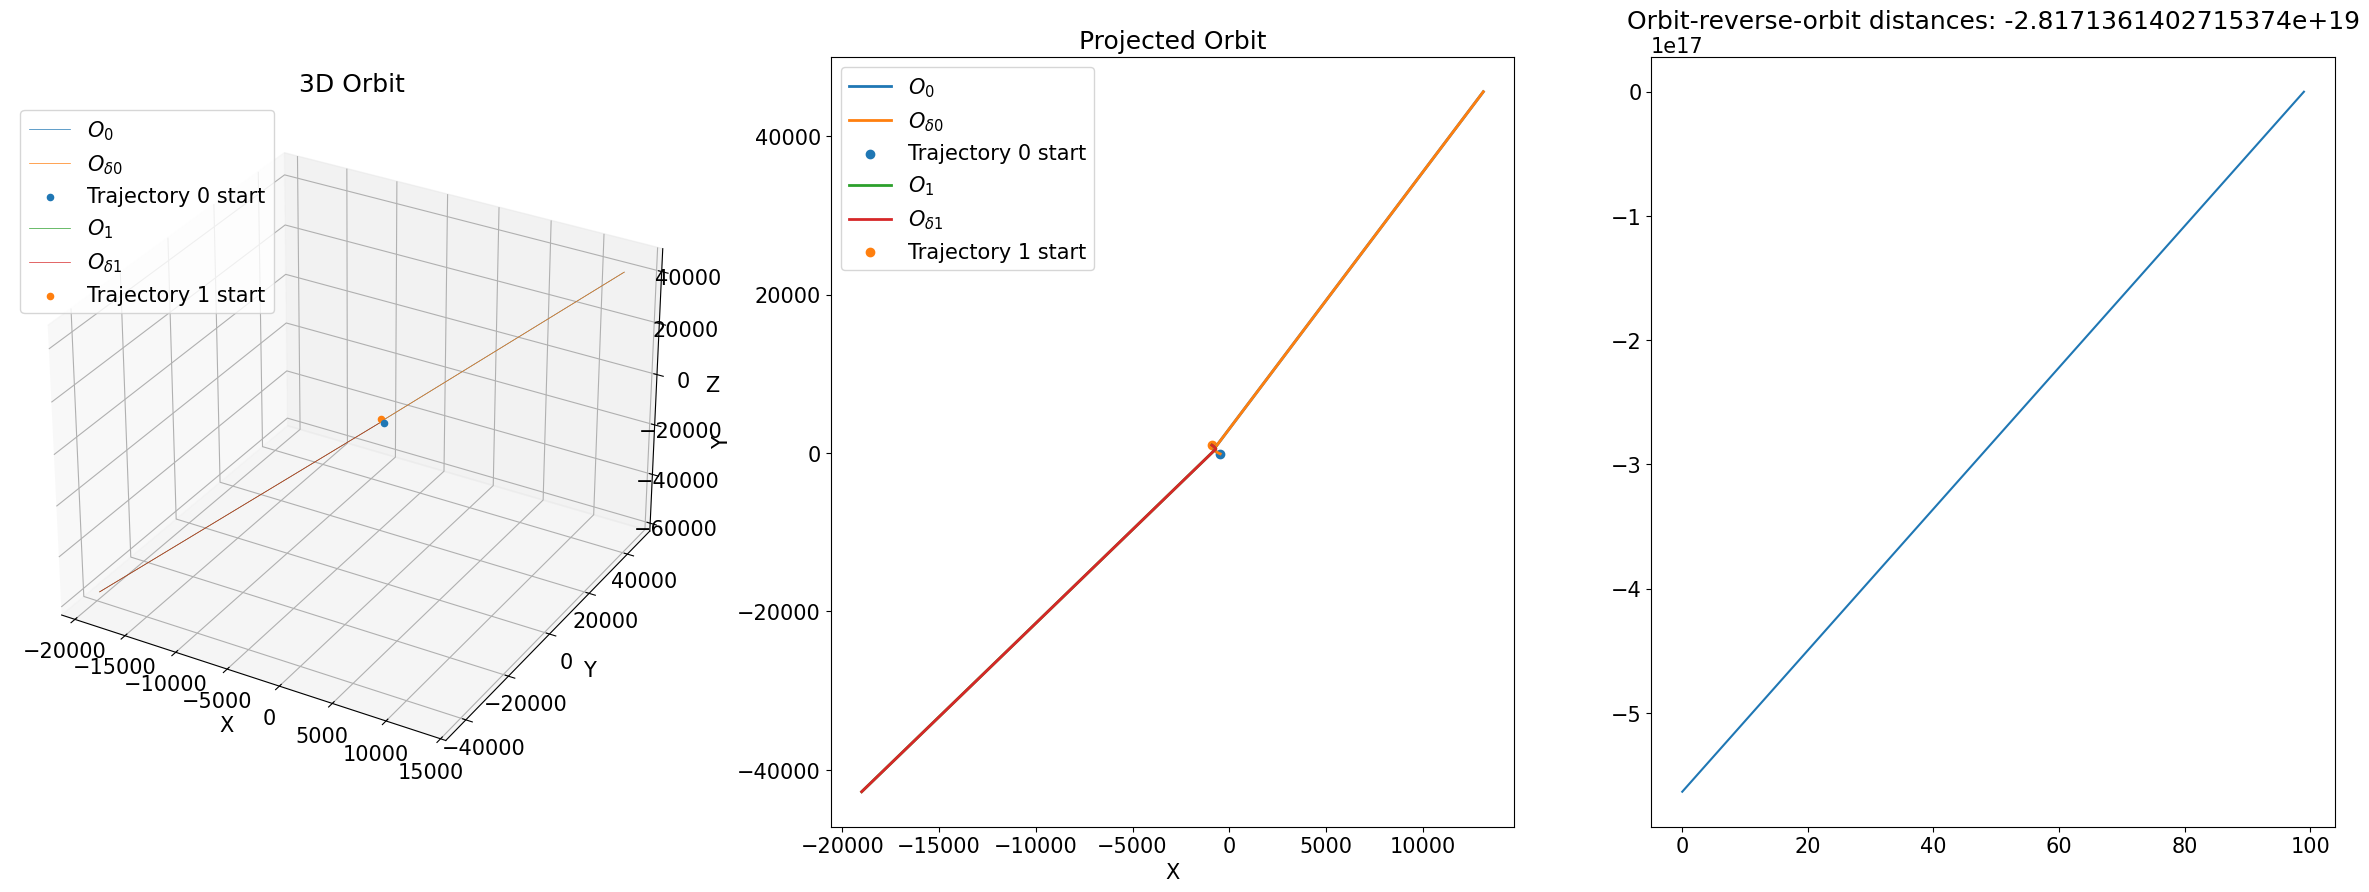

In [7]:
plot_from_init(result_to_init(0))

{0: array([  486.21218872,  -182.8843689 , -1000.        ,    73.09805298,
         -63.92471695,    14.08009815]), 1: array([ 654.63226318, -508.61508179,  139.00550842,   52.09164047,
         -5.98747444,  100.        ])}
{0: np.float64(6.334127602852563e-16), 1: np.float64(1.0098582848004023e-15)}


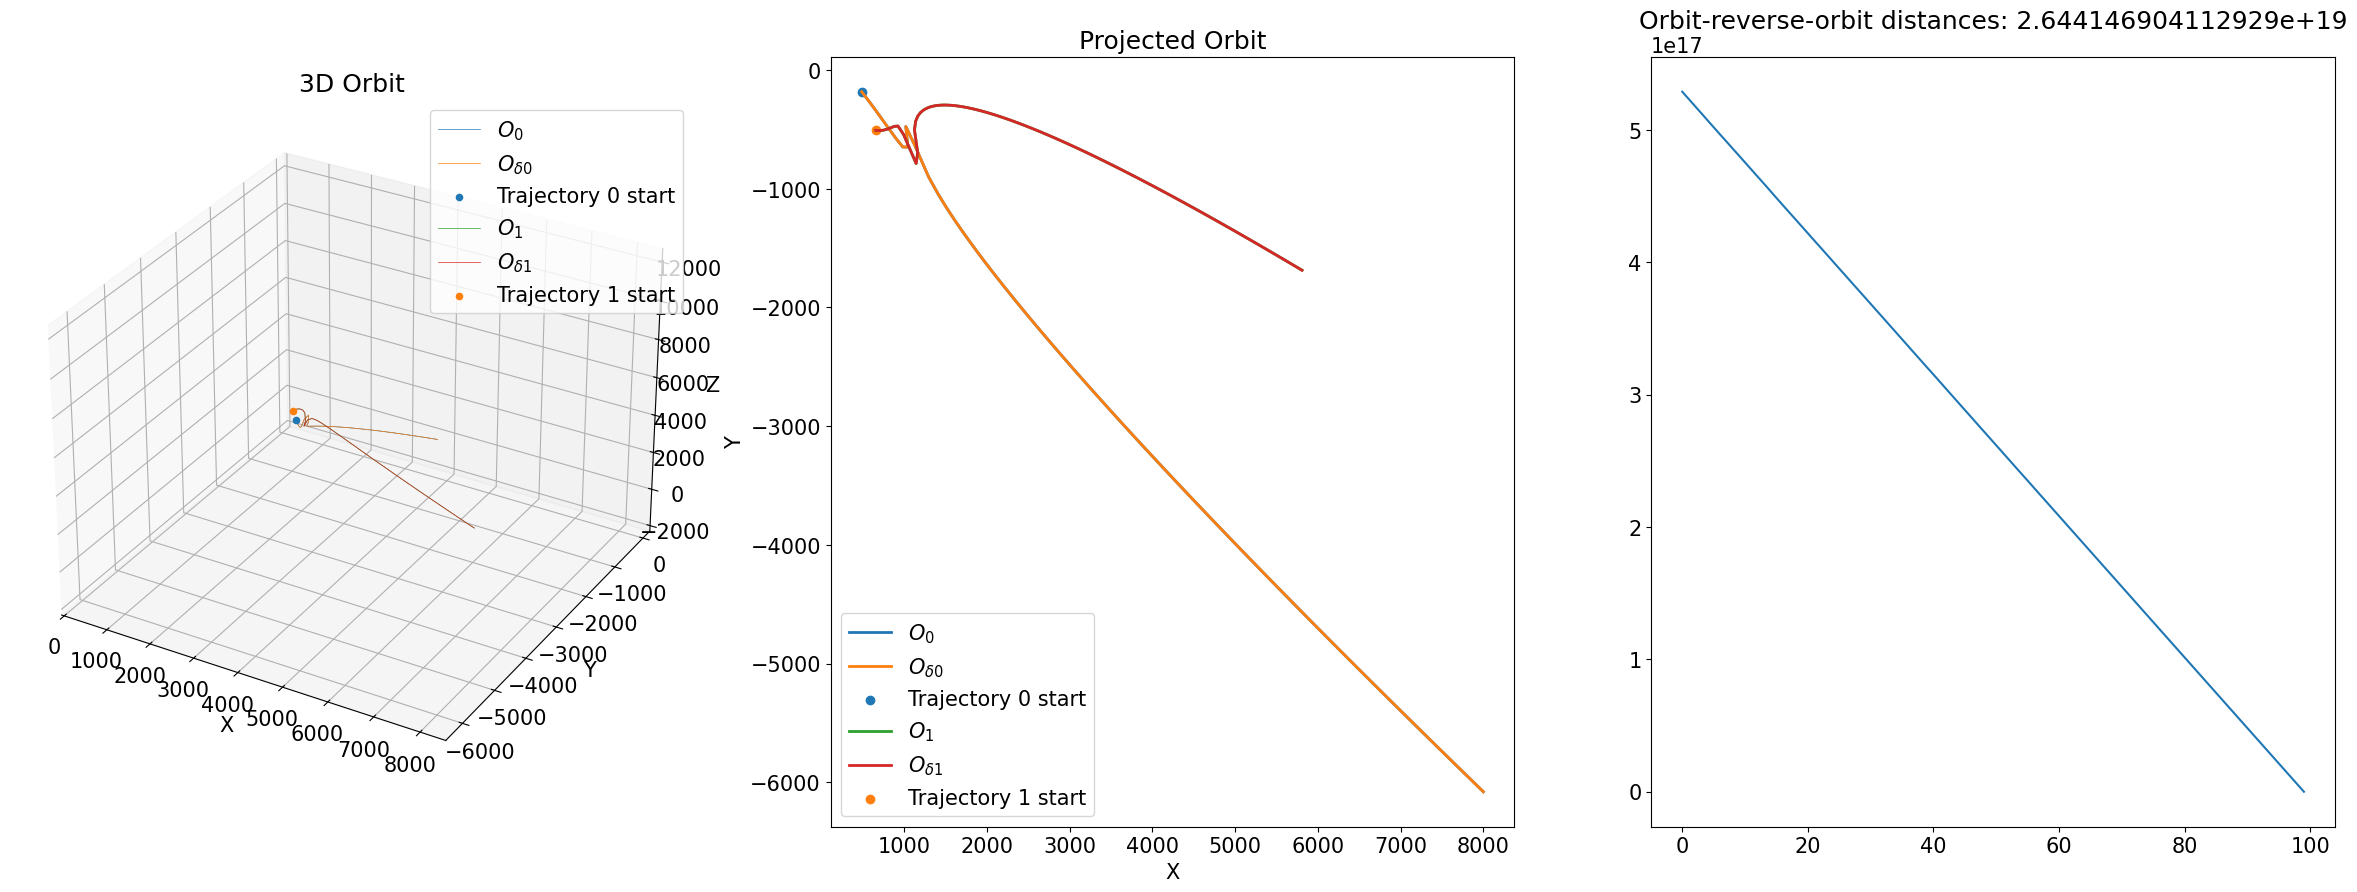

In [8]:
plot_from_init(result_to_init(1))

{0: array([-466.10391235,  223.74627686, -387.79431152,  100.        ,
         48.33143616, -100.        ]), 1: array([ 115.52482605, -583.64379883, 1000.        ,  -96.44944   ,
        -83.3762207 ,   88.69592285])}
{0: np.float64(3.2472562982690296e-16), 1: np.float64(3.852772380583475e-16)}


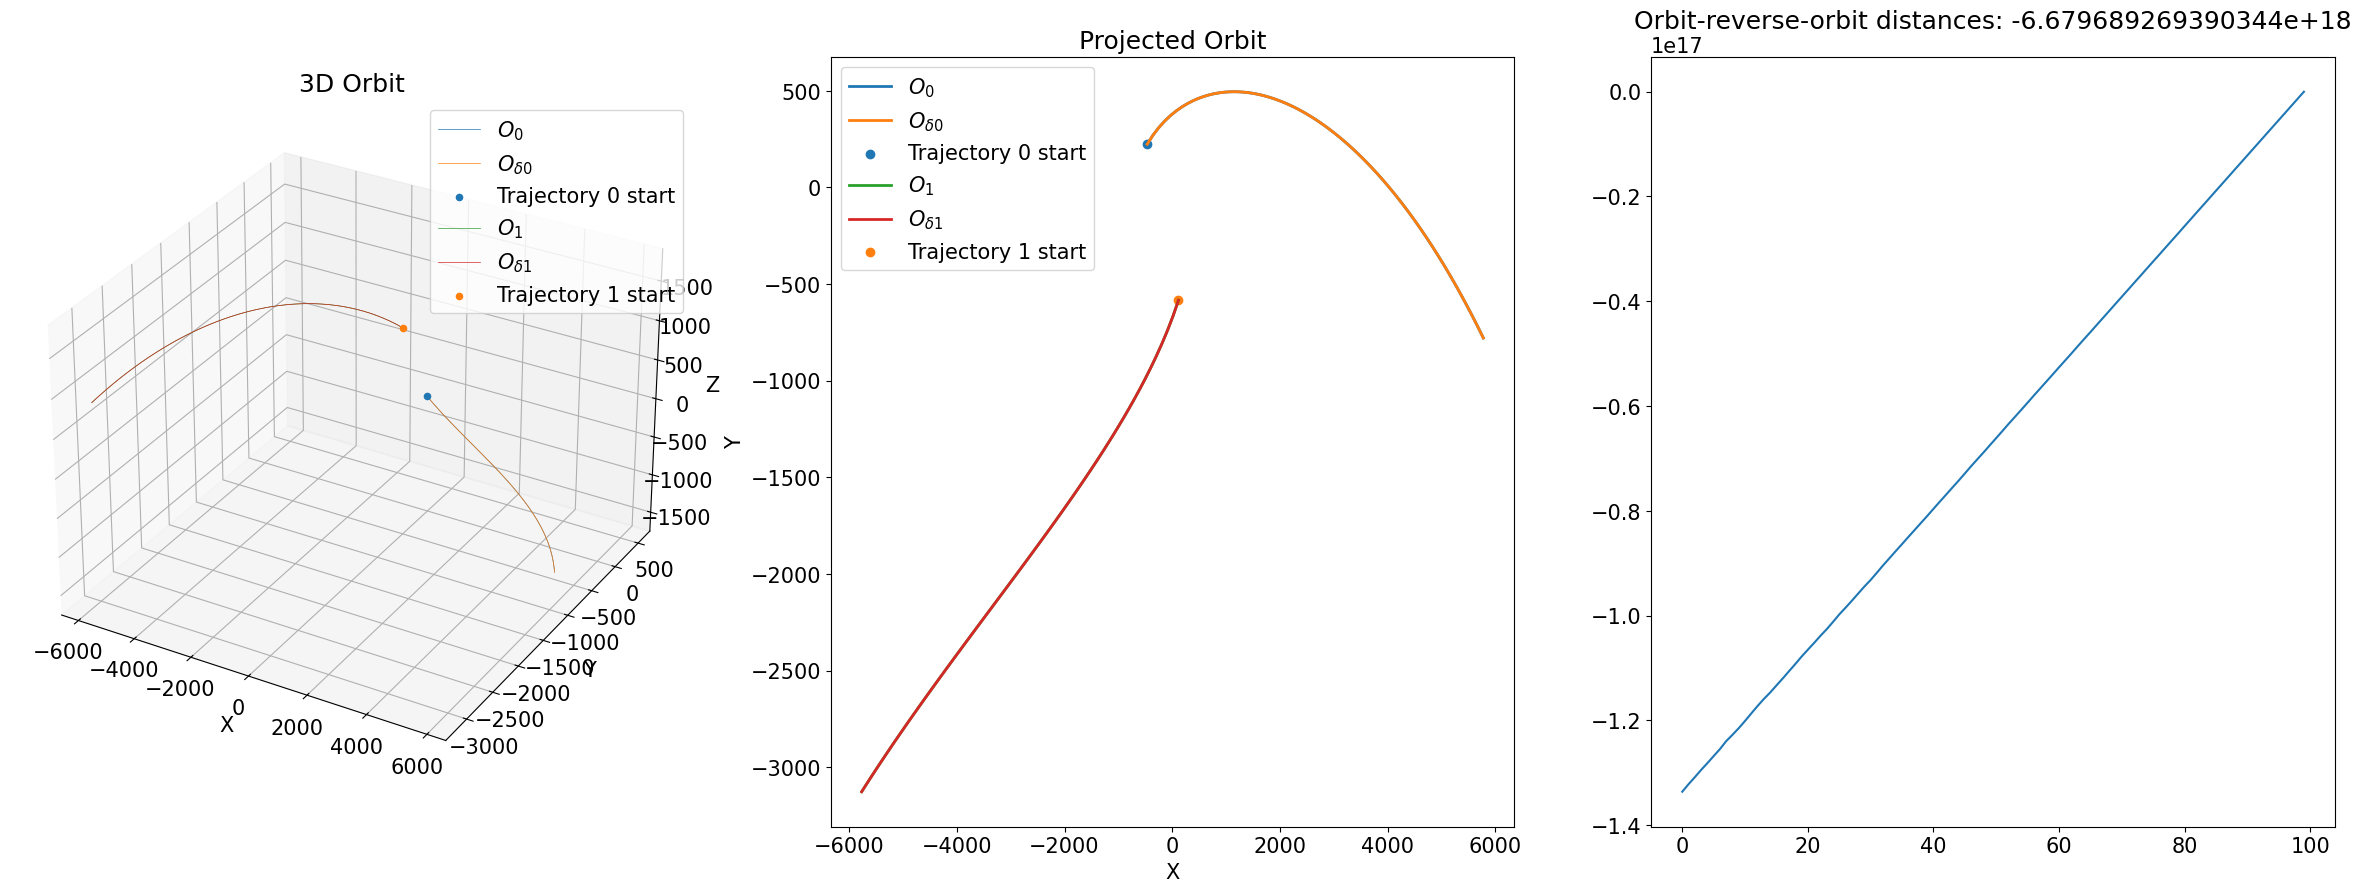

In [9]:
plot_from_init(result_to_init(2))

{0: array([  751.6161499 , -1000.        ,  1000.        ,   -16.94377708,
         -84.54311371,    47.72779465]), 1: array([ 1000.        ,  -216.26469421, -1000.        ,   100.        ,
          29.36909103,   100.        ])}
{0: np.float64(3.189255384985833e-16), 1: np.float64(3.193809827626702e-16)}


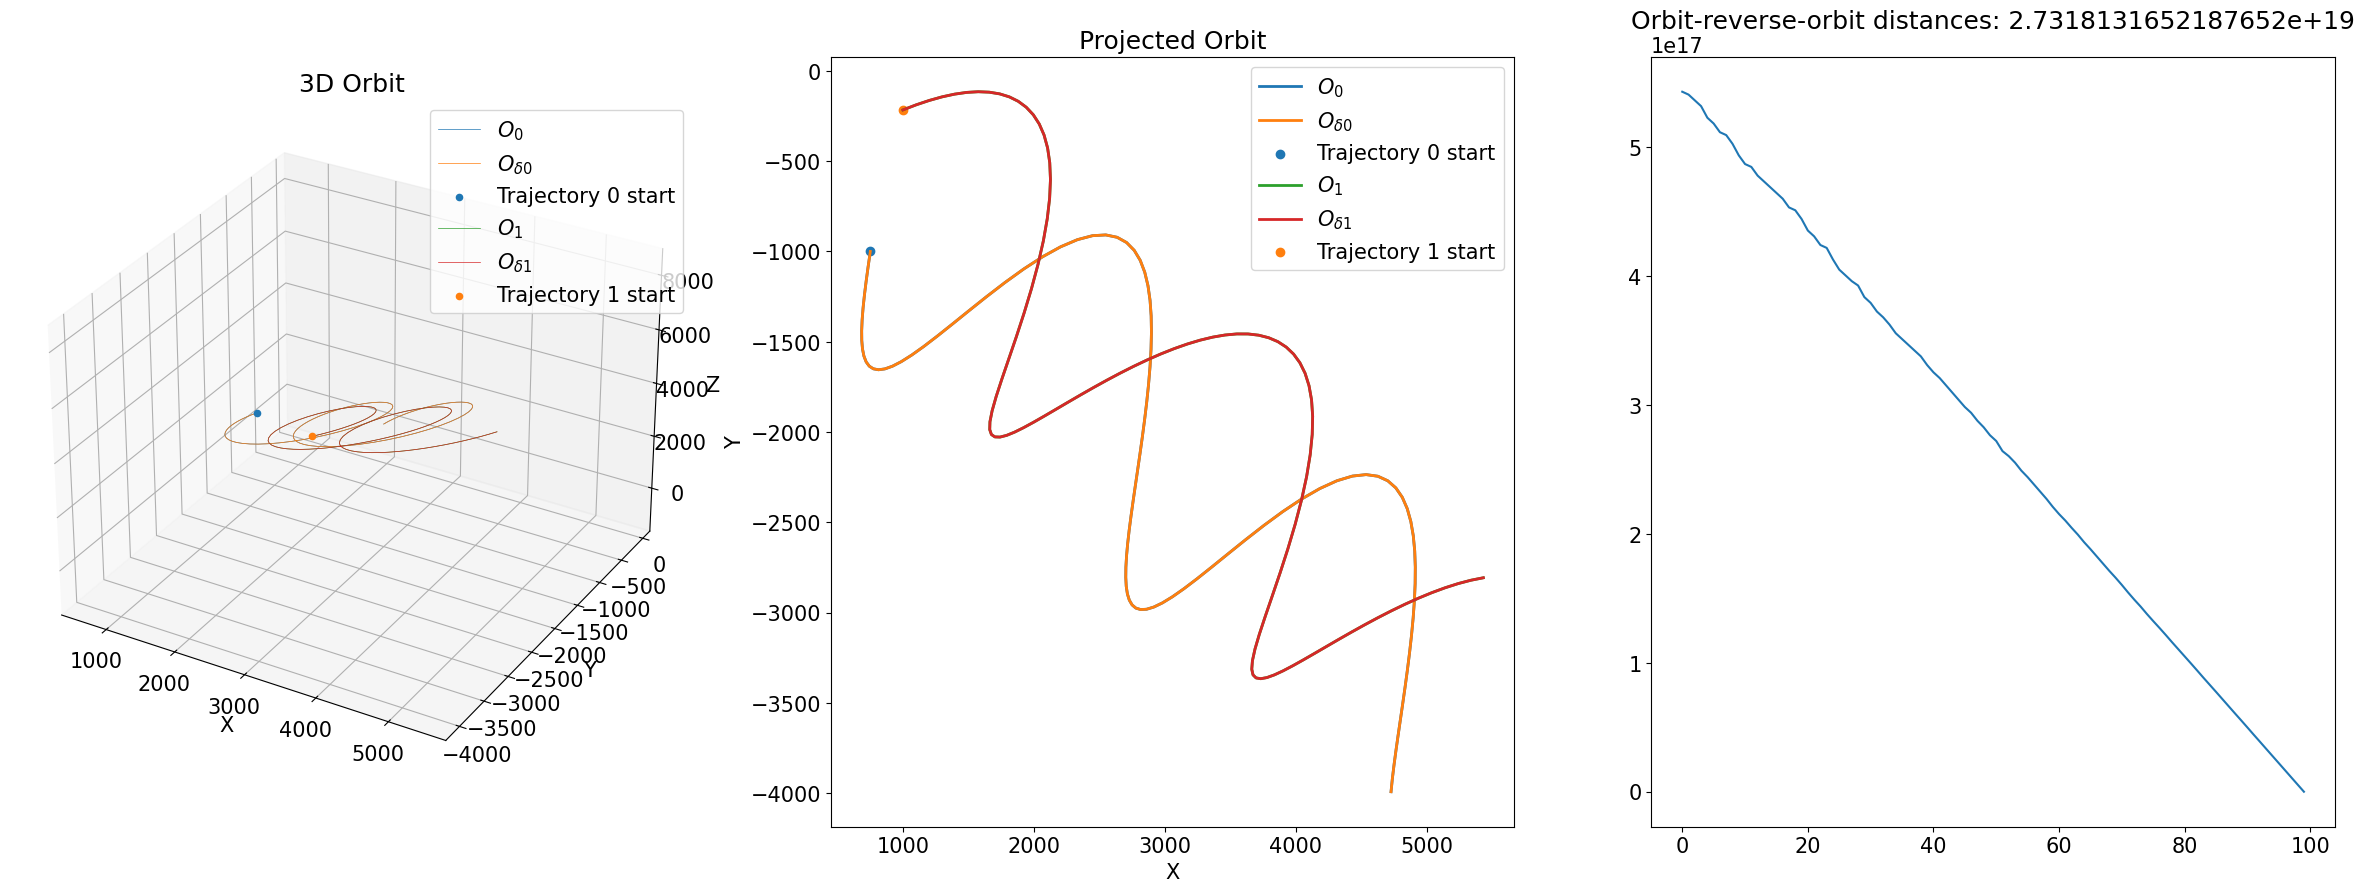

In [10]:
plot_from_init(result_to_init(3))

{0: array([ 828.78808594, -704.0378418 , -789.918396  ,  100.        ,
        -58.31264114, -100.        ]), 1: array([-1.00000000e+03,  1.18685928e+02, -7.51783325e+02,  3.47167130e+01,
        7.59955978e+01,  8.88002455e-01])}
{0: np.float64(3.2333483350926695e-16), 1: np.float64(4.0372986243276823e-16)}


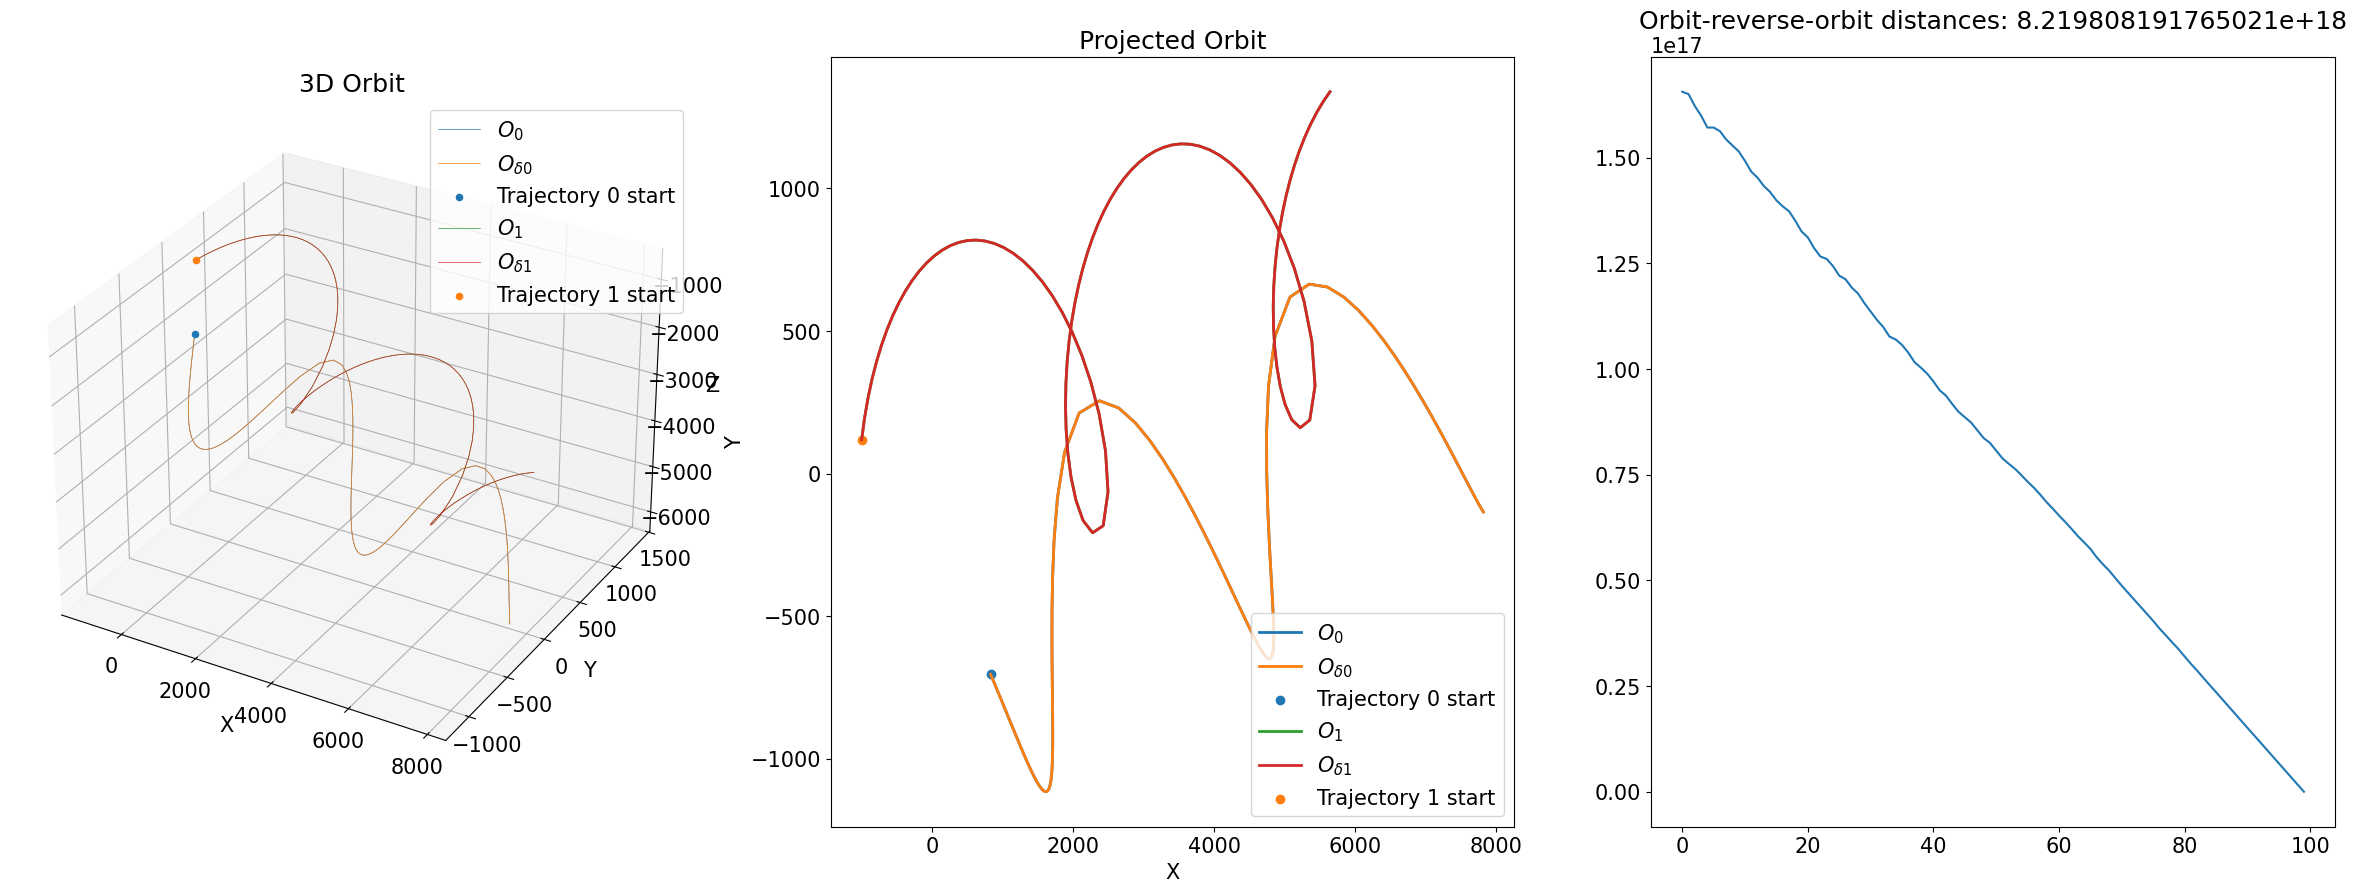

In [11]:
plot_from_init(result_to_init(4))

{0: array([-669.36230469,  140.96266174,  892.68731689,  -99.19467163,
         54.10694504,   23.90998077]), 1: array([1000.        , 1000.        , -812.42034912,  100.        ,
       -100.        ,   37.99971008])}
{0: np.float64(3.9540757121647336e-16), 1: np.float64(2.642080398701066e-16)}


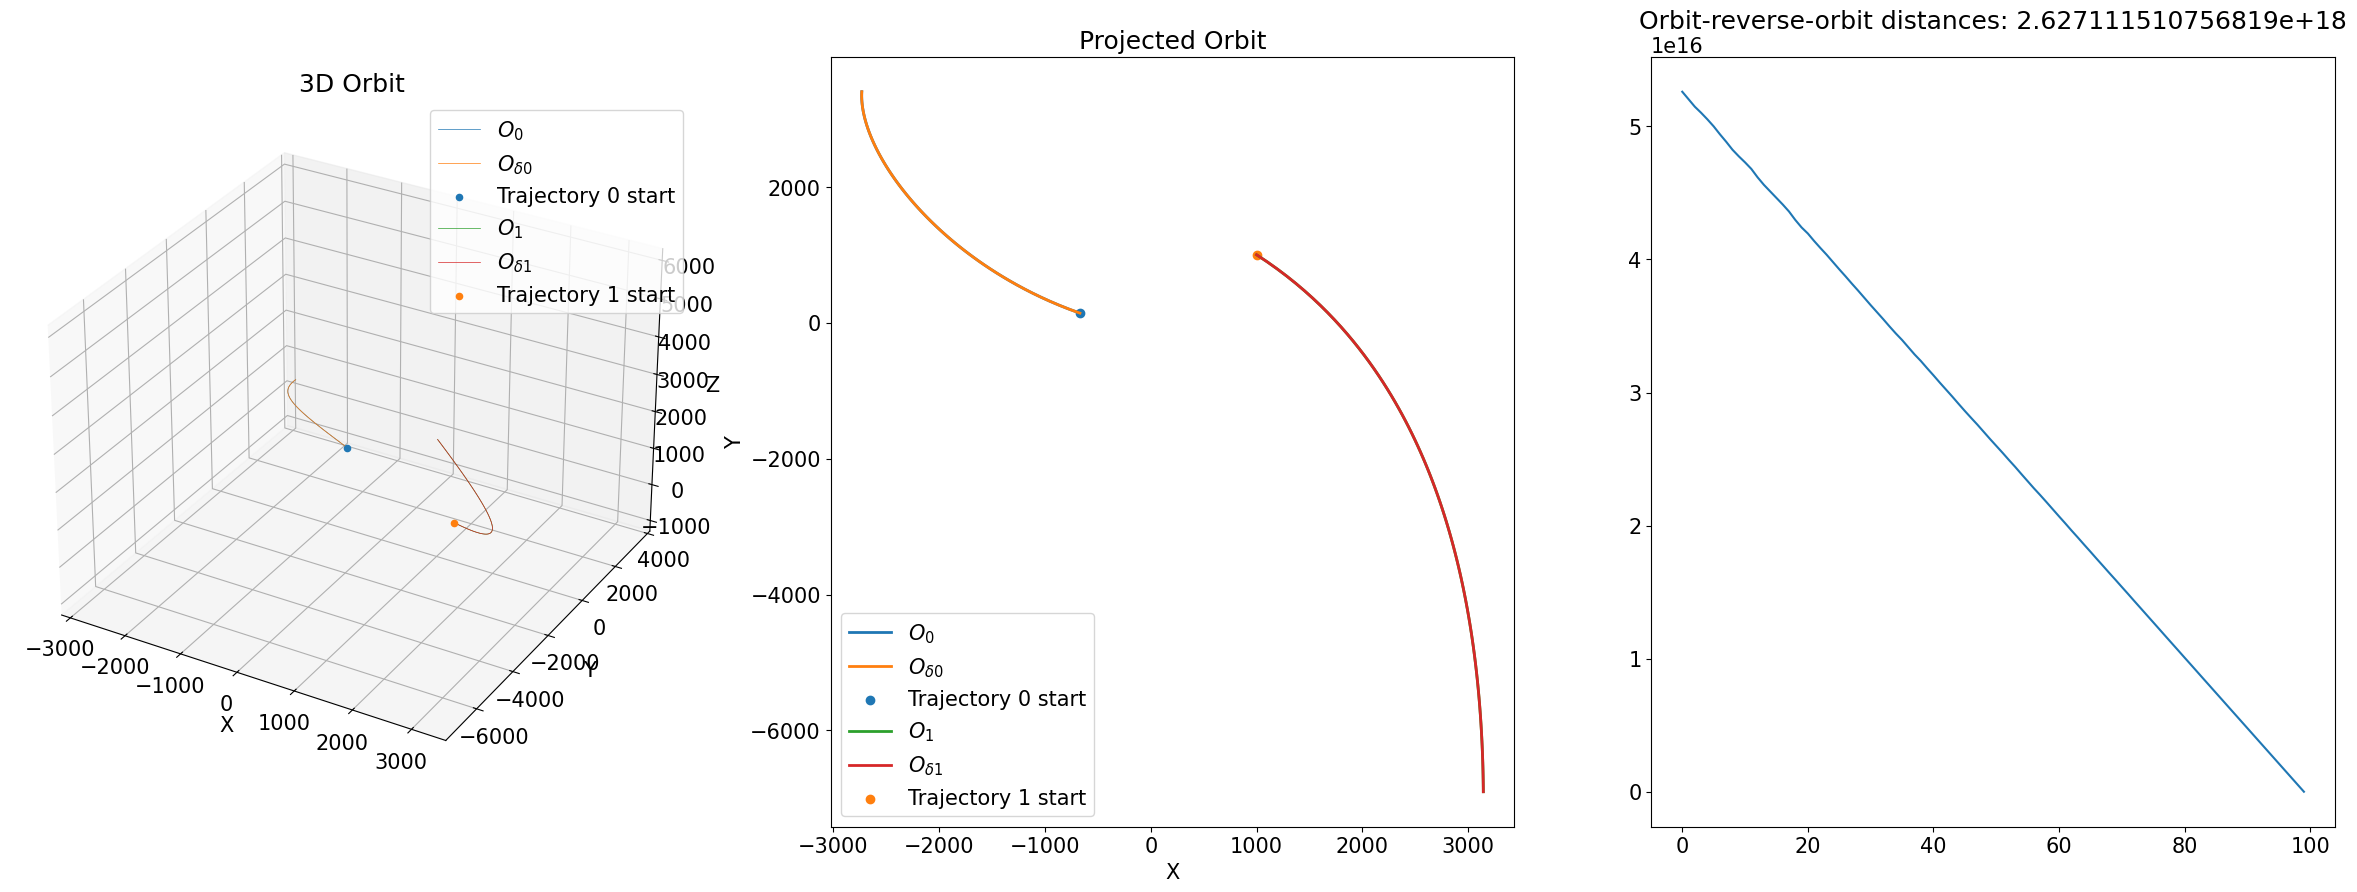

In [12]:
plot_from_init(result_to_init(5))